# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name="../../environments/banana_visual_unity_env/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
numpy shape: (1, 3, 84, 84)
States look like:


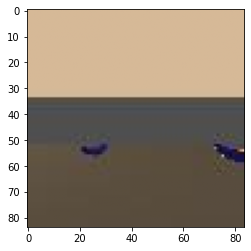

States have shape: (1, 84, 84, 3)


In [22]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
state_numpy = np.asarray(state)
state_numpy = np.reshape(state_numpy, (1, 3, 84, 84))
state = state_numpy
state = np.reshape(state_numpy, (1, 84, 84, 3))
print(f"numpy shape: {state_numpy.shape}")
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.visual_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

NameError: name 'action_size' is not defined

When finished, you can close the environment.

In [8]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
!pip install torchvision

In [1]:
# TESTING CHATGPT CORRECTIONS ON DOUBLE DQN AND DUELING DQN. REMOVED PRIORITIZED EXPERIENCE REPLAY FOR NOW BECAUSE IT HINDERS THE TRAINING

import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms


class QNetwork(nn.Module):
    """Actor (Policy) Model.
    
    As the paper Human-level control through deep reinforcement learning:
    "The exact architecture, shown schematically in Fig. 1, is as follows. The input to
    the neural network consists of an 84 X 84 X 4 image produced by the preprocessing map w. 
    The first hidden layer convolves 32 filters of 8 3 8 with stride 4 with the
    input image and applies a rectifier nonlinearity. The second hidden layer 
    convolves 64 filters of 4 3 4 with stride 2, again followed by a rectifier nonlinearity.
    This isfollowed by a third convolutional layer that convolves 64filters of 3 3 3 with
    stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists 
    of 512 rectifier units. The output layer is a fully-connected linear layer with a
    single output for each valid action. The number of valid actions varied between 4
    and 18 on the games we considered."
    
    """

    def __init__(self, state_size, action_size, seed, name="local",grayscale=True):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.input_size = state_size
        print(f"Network input size: {self.input_size}")
        self.output_size = action_size
        self.seed = torch.manual_seed(seed)
        self.transform = transforms.Grayscale()
        self.grayscale = grayscale
        self.name = name
        
        # FROM THE PAPER
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=4, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Advantage values
        self.fc2_a = nn.Linear(64*10*10, 256)
        self.fc3_a = nn.Linear(256, action_size)

        # State value
        self.fc2_s = nn.Linear(64*10*10, 256)
        self.fc3_s = nn.Linear(256, 1)

    def preprocess_input(self, state):
#         return torch.reshape(state, (-1, *self.input_size))
        return torch.reshape(state, (-1, 3, 84, 84))
#         return self.transform(state, axis=1)
        

    def forward(self, state):
#         if self.grayscale:
#             x = self.preprocess_input(state)
        
        
#         x = F.relu(self.conv1(x))
#         x = self.pool1(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool2(x)
#         x = self.fc(x)

        print(f"Network {self.name} forward pass. state shape: {state.shape}")
        x = self.preprocess_input(state)
        print(f"Network {self.name} after reshape. state shape: {state.shape}")
#         x = F.relu(self.pool1(self.conv1(x)))
#         x = F.relu(self.pool2(self.conv2(x)))
#         x = F.relu(self.pool3(self.conv3(x)))
        print(f"X Shape after 3 convs: {x.shape}")
        x = F.relu(self.conv1(x))
        print(f"X Shape after 3 convs: {x.shape}")
        x = F.relu(self.conv2(x))
        print(f"X Shape after 3 convs: {x.shape}")
        x = F.relu(self.conv3(x))
        print(f"X Shape after 3 convs: {x.shape}")
        x = x.view(-1, 64*10*10) 
        print(f"X Shape after 3 convs: {x.shape}")
        # Advantage net
        advantage = F.relu(self.fc2_a(x))
        advantage = self.fc3_a(advantage)
        
        # State value net
        state_value = F.relu(self.fc2_s(x))
        state_value = self.fc3_s(state_value)
        
        # Concat
        q_values = state_value + advantage - advantage.mean()
        return q_values
    

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, 
                 state_size, 
                 action_size,
                 t_step=0,
                 model_path=None,
                 buffer_size=int(1e5),
                 batch_size=64,
                 gamma=0.99,
                 tau=1e-3,
                 learning_rate=5e-4,
                 update_every=4,
                 seed=0):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Q-Network
        if not model_path:
            self.qnetwork_local = QNetwork(state_size, action_size, seed, "local").to(self.device)
            self.qnetwork_target = QNetwork(state_size, action_size, seed, "target").to(self.device)
            self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)
            self.training = True
        else:
            print(f"Loading model from file {model_path}")
            self.qnetwork_local = QNetwork(state_size, action_size, seed, "local").to(self.device)
            self.qnetwork_target = QNetwork(state_size, action_size, seed, "target").to(self.device)
            self.qnetwork_local.load_state_dict(torch.load(model_path))
            self.qnetwork_target.load_state_dict(torch.load(model_path))
            self.training = False
        
        # Replay memory
#         self.memory = PrioritizedReplayBuffer(action_size, buffer_size, batch_size, seed, self.device)
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed, self.device)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = t_step
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.learning_rate = learning_rate
        self.update_every = update_every
        

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences      

#         # Compute target values: # reward + gamma * max(Q(s', a')) * (1-done)
#         td_targets_next_states = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
#         td_targets = rewards + (gamma*td_targets_next_states * (1-dones))
        
        """
        TODO: IMPLEMENT DOUBLE DQN: INSTEAD OF CALCULATING THE MAX VALUE USING THE TARGET NETWORK, 
        WE WILL GET THE INDEX OF THE ACTION USING THE LOCAL NETWORK. WITH THIS INDEX, WE WILL GET THE VALUE CALCULATED
        USING THE TARGET NETWORK
        
        From the paper:
        "In the original Double Q-learning algorithm, two value
        functions are learned by assigning each experience randomly to update one of the two value functions, such that
        there are two sets of weights, θ and θ`. For each update, one
        set of weights is used to determine the greedy policy and the
        other to determine its value. For a clear comparison, we can
        first untangle the selection and evaluation in Q-learning..."
        
        PSEUDOCODE
        td_targets_next_states_indexes = np.argmax(self.qnetwork_local(next_states), axis=1)
        td_targets_next_states = self.qnetwork_target(next_states).gather(td_targets_next_states_indexes)
        
        """
#         td_targets_next_states_indexes = np.argmax(self.qnetwork_local(next_states).detach(), axis=1).unsqueeze(1) # Get the action index using the local network
#         td_targets_next_states = self.qnetwork_target(next_states).detach().gather(1, td_targets_next_states_indexes) # use the indexes to get the values from the target network
#         td_targets = rewards + (gamma*td_targets_next_states * (1-dones)) # calculate the target just as before
    
        # Get index of max Q values of next states from local model
        next_state_actions = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1) # DOES THIS RETURN THE INDEX OF THE MAX VALUE????

        # Get max Q values of next states from target model
        td_targets_next_states = self.qnetwork_target(next_states).gather(1, next_state_actions)

        # Compute Q targets for current states 
        td_targets = rewards + (gamma * td_targets_next_states * (1 - dones))    
    
        
        # Current Q values
        q_values_local = self.qnetwork_local(states).gather(1, actions) # Q
        
        # compute loss
        loss = F.mse_loss(q_values_local, td_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- # # Only update the target network after we pass on the samples
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)                     

        
        

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

            
    def calculate_error_delta(self, state, action, reward, next_state, done):
        """
        TODO: compute the error delta for the current state, action, reward and next_stat set
        """
        # Compute target values: # reward + gamma * max(Q(s', a')) * (1-done)
        # transform input state to torch structure
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(self.device)
        action = np.asarray(action)
        action = torch.from_numpy(action).long().unsqueeze(0).to(self.device)
        action = action.expand(1,1)
#         print(f"State: {state.size()}. Next state: {next_state.size()}. Action: {action.size()}")
        
        # VANILA DQN. DO DOUBLE DQN LATER
#         td_targets_next_state = self.qnetwork_target(next_state).detach().max(1)[0].unsqueeze(1)
#         td_target = reward + (gamma*td_targets_next_state * (1-done)) # Target
        
        # Using double DQN
        td_targets_next_states_indexes = np.argmax(self.qnetwork_local(next_state).detach(), axis=1).unsqueeze(1) # Get the action index using the local network
        td_targets_next_states = self.qnetwork_target(next_state).detach().gather(1, td_targets_next_states_indexes) # use the indexes to get the values from the target network
        td_target = reward + (gamma*td_targets_next_states * (1-done)) # calculate the target just as before
        
        # CHATGPT VERSION
#         # Get index of max Q values of next states from local model
#         next_state_actions = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1) # DOES THIS RETURN THE INDEX OF THE MAX VALUE????

#         # Get max Q values of next states from target model
#         td_targets_next_states = self.qnetwork_target(next_states).gather(1, next_state_actions)

#         # Compute Q targets for current states 
#         td_targets = rewards + (gamma * td_targets_next_states * (1 - dones))  
        
        q_value_local = self.qnetwork_local(state).gather(1, action) # Q current
        return abs(td_target - q_value_local)

            
    def step(self, state, action, reward, next_state, done):
        
        """
        TODO: add error delta to the memory along each entry
        """
#         error = self.calculate_error_delta(state, action, reward, next_state, done)
#         # Save experience in replay memory
#         self.memory.add(state, action, reward, next_state, done, error)

        
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)        
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

                
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
#         state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        print(f"Agent.act method before torch conversion. state shape: {state.shape}.")    
        state = torch.from_numpy(state).float().to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            print(f"Agent.act method. state shape: {state.shape}.")
            action_values = self.qnetwork_local(state)
            
        if self.training:
            self.qnetwork_local.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    
class ReplayBuffer: 
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [2]:
import numpy as np
import time

# def dqn(agent, env, brain_name, model_name="dqn_3fc_act_nodrop", n_episodes=2000, max_t=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
def dqn(agent, model_name="dqn_3fc_act_nodrop", n_episodes=2000, max_t=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    timestr = time.strftime("%Y%m%d-%H%M%S")
    best = 0
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    episode_start = time.time()

    from unityagents import UnityEnvironment
    env = UnityEnvironment(file_name="../../environments/banana_visual_unity_env/Banana.exe")
    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
#     examine the state space 
    state = env_info.visual_observations[0]
    
    plt.imshow(np.squeeze(state))
    plt.show()
    state_size = state.shape
    
    for i_episode in range(1, n_episodes+1):
#         env_info = env.reset(train_mode=True)[brain_name]
#         print(f"Environment reset.")
#         state = env_info.vector_observations[0]
# #         plt.imshow(np.squeeze(state))
# #         plt.show()   
        
        score = 0
#         break
        for t in range(max_t):
            
#             if state.shape[0] == 0:
#                 print(f"State = 0. Skipping.")
#                 continue
            print(f'Env reset. State shape: {state.shape}. Look like:')
            action = agent.act(state, eps)
            print(f"Action: {action}")
            env_info = env.step(action.astype(np.int32))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]   
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}\tAverage steps per second:{}'.format(i_episode, np.mean(scores_window), t/(time.time()-episode_start)), end="")
        episode_start = time.time()
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=5.0 and np.mean(scores_window)>best:
            best = np.mean(scores_window)
#             print(f"\nOverwriting last checkpiont with current average score: {best}")
            filename = model_name + timestr + f"-score-{int(np.mean(scores_window))}" + ".pth"
            torch.save(agent.qnetwork_local.state_dict(), filename)
            
    return scores

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


States look like:


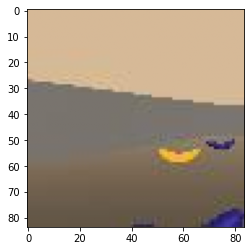

States have shape: (1, 84, 84, 3)


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

env = UnityEnvironment(file_name="../../environments/banana_visual_unity_env/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

Network input size: (1, 84, 84, 3)
Network input size: (1, 84, 84, 3)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


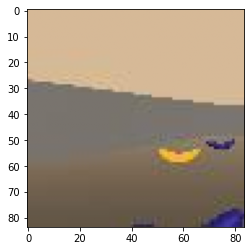

Env reset. State shape: (1, 84, 84, 3). Look like:
Agent.act method before torch conversion. state shape: (1, 84, 84, 3).
Agent.act method. state shape: torch.Size([1, 84, 84, 3]).
Network local forward pass. state shape: torch.Size([1, 84, 84, 3])
Network local after reshape. state shape: torch.Size([1, 84, 84, 3])
X Shape after 3 convs: torch.Size([1, 3, 84, 84])
X Shape after 3 convs: torch.Size([1, 32, 20, 20])
X Shape after 3 convs: torch.Size([1, 64, 10, 10])
X Shape after 3 convs: torch.Size([1, 64, 10, 10])
X Shape after 3 convs: torch.Size([1, 6400])
Action: 3
Env reset. State shape: (0,). Look like:
Agent.act method before torch conversion. state shape: (0,).
Agent.act method. state shape: torch.Size([0]).
Network local forward pass. state shape: torch.Size([0])
Network local after reshape. state shape: torch.Size([0])
X Shape after 3 convs: torch.Size([0, 3, 84, 84])
X Shape after 3 convs: torch.Size([0, 32, 20, 20])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape

Agent.act method. state shape: torch.Size([0]).
Network local forward pass. state shape: torch.Size([0])
Network local after reshape. state shape: torch.Size([0])
X Shape after 3 convs: torch.Size([0, 3, 84, 84])
X Shape after 3 convs: torch.Size([0, 32, 20, 20])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 6400])
Action: 2
Env reset. State shape: (0,). Look like:
Agent.act method before torch conversion. state shape: (0,).
Agent.act method. state shape: torch.Size([0]).
Network local forward pass. state shape: torch.Size([0])
Network local after reshape. state shape: torch.Size([0])
X Shape after 3 convs: torch.Size([0, 3, 84, 84])
X Shape after 3 convs: torch.Size([0, 32, 20, 20])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 6400])
Action: 0
Env reset. State shape: (0,). Look like:
Agent.act metho

Agent.act method. state shape: torch.Size([0]).
Network local forward pass. state shape: torch.Size([0])
Network local after reshape. state shape: torch.Size([0])
X Shape after 3 convs: torch.Size([0, 3, 84, 84])
X Shape after 3 convs: torch.Size([0, 32, 20, 20])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 6400])
Action: 3
Env reset. State shape: (0,). Look like:
Agent.act method before torch conversion. state shape: (0,).
Agent.act method. state shape: torch.Size([0]).
Network local forward pass. state shape: torch.Size([0])
Network local after reshape. state shape: torch.Size([0])
X Shape after 3 convs: torch.Size([0, 3, 84, 84])
X Shape after 3 convs: torch.Size([0, 32, 20, 20])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 6400])
Action: 2
Env reset. State shape: (0,). Look like:
Agent.act metho

X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 6400])
Action: 1
Env reset. State shape: (0,). Look like:
Agent.act method before torch conversion. state shape: (0,).
Agent.act method. state shape: torch.Size([0]).
Network local forward pass. state shape: torch.Size([0])
Network local after reshape. state shape: torch.Size([0])
X Shape after 3 convs: torch.Size([0, 3, 84, 84])
X Shape after 3 convs: torch.Size([0, 32, 20, 20])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 64, 10, 10])
X Shape after 3 convs: torch.Size([0, 6400])
Action: 0
Env reset. State shape: (0,). Look like:
Agent.act method before torch conversion. state shape: (0,).
Agent.act method. state shape: torch.Size([0]).
Network local forward pass. state shape: torch.Size([0])
Network local after reshape. state shape: torch.Size([0])
X Shape after 3 convs: torch.Size([0, 3, 84, 84])
X Sha

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 30 has 4 dimension(s)

In [3]:
t_step = 0
alpha = 0.1
gamma = 0.99
epsilon = 0.99
state_size = (1, 84,84,3)
agent = Agent(state_size=state_size, 
              action_size=4,
              t_step=t_step,
              gamma=gamma,
              seed=0)

scores = dqn(agent, 
#              env, 
#              brain_name, 
             n_episodes=2000, 
             max_t=1000, 
             eps_start=1.0, 
             eps_end=0.01, 
             eps_decay=0.995)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()